# Small Temporal Density Variations


The following code is used to visualise density varitions from photographs of a moving ridge in the lab. The code firstly takes a background photograph, finds the density profile then compares said profile to photographs taken of the moving ridge.

In [1]:
%matplotlib qt
#notebook backend important
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os.path
import cv2
from matplotlib import rc
from tkinter.filedialog import askopenfilename
from tkinter.filedialog import askopenfilenames
import matplotlib.animation as animation
import cmocean as cmo
import time

In [14]:
#A simple function used when clicking of photos to determine where in an array the click is
def index_find(depths,click):
    lst = depths<click
    for i,v in enumerate(lst):
        if v==True:
            return i

## Loading the data from the experiments 

In [3]:
excel_path = askopenfilename() #path to excel doc with data
data = pd.read_excel(excel_path)

In [4]:
%matplotlib qt

run_num = int(input('Run number:'))
print('Data read')
#getting data from excel doc
rho_bottom = data.iloc[run_num-1, 7]
rho_top = data.iloc[run_num-1, 6]
depth = data.iloc[run_num-1, 2]

Run number:8
Data read


## Analysing the background image

In [5]:
#now choose background image, this image should not contain topography

background_path = askopenfilename() 
b_image = cv2.imread(background_path,0)

Now we choose the area of photograph we want to average over to create a background stratification profile. The top of the region should be the free surface and the bottom should be the base of the tank.

In [6]:
plt.figure()
plt.title('Choose Area to Average over')
plt.axis('off')
plt.imshow(b_image, cmap='gist_gray')
print('Select the top then the bottom' )
density_locations = plt.ginput(2)
print('Locations recorded')

zbot_0=int(np.round(density_locations[0][1]))
ztop_0=int(np.round(density_locations[1][1]))

back_crop= b_image[zbot_0:ztop_0,:]

log_back = np.log(back_crop)

#getting rid of unwated inf_values
log_back[np.isinf(log_back)]=np.nan

intensity = np.float32(log_back)
depth_array = -np.linspace(0,depth,intensity.shape[0])

Select the top then the bottom
Locations recorded


In [7]:
#determining the location of density samples top then bottom
length_ratio = depth/intensity.shape[0]

plt.figure()
plt.title('Density Sample Locations')
plt.ylabel('z (m)')
plt.xlabel('x (m)')
plt.imshow(intensity, cmap='gist_gray', extent=[0,length_ratio*intensity.shape[1],-depth,0])
print('Position of density sample close to top, then close to bottom' )
density_locations = plt.ginput(2)
print('Locations recorded')

zbot_rho=index_find(depth_array,density_locations[1][1])
ztop_rho=index_find(depth_array,density_locations[0][1])

middle= int(intensity.shape[1]/2)
intensity_average=np.mean(intensity[:,middle-10:middle+10],axis=1)


beta = (rho_bottom-rho_top)/(intensity_average[zbot_rho]-intensity_average[ztop_rho])
bottom_ref = intensity_average[zbot_rho]

rho_ref=rho_bottom+np.float64(beta*(intensity-bottom_ref))


Position of density sample close to top, then close to bottom
Locations recorded


In [8]:
#now plotting background density field
plt.figure()
im=plt.imshow(rho_ref,vmin=rho_top,vmax=rho_bottom, extent=[0,length_ratio*intensity.shape[1],-depth,0])
plt.title('Background Density')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar=plt.colorbar(im, cax=cax)
cbar.set_label(r'Density (kg m$^{-3}$)', rotation=90)
cbar.ax.invert_yaxis()

## Foreground Images
Choose the rapid foreground images you want in order to make a video of the moving ridge in density space


In [11]:
#now choose the pictures you want to look over, also creates a folder to save the video
foreground_path = askopenfilenames()
no_images = len(foreground_path)
os.mkdir('{}/densityfields2'.format(os.path.dirname(foreground_path[0])))

In [12]:
%matplotlib inline
print('{} Images to analyse!'.format(no_images))
#inline backend used to stop hundreds of plots occuring, very important!!!!!!!

279 Images to analyse!


In [ ]:
#first doing density

ims=[]
fig = plt.figure(figsize=(10,5))

y,x=rho_ref.shape
#density_anomaly = np.zeros((no_images,y,x))
density_abs = np.zeros((no_images,y,x))


for i in range(no_images):

    f_image=cv2.imread(foreground_path[i],0)
    f_image_crop=f_image[zbot_0:ztop_0,:]
    absorbtion = np.log(f_image_crop)

    #getting rid of unwated inf_values and converting to density
    absorbtion[np.isinf(absorbtion)]=np.nan
    density = rho_bottom+np.float64(beta*(absorbtion-bottom_ref))
    
    
    cmap = cmo.cm.balance
    vmin=-2
    vmax=-vmin
        
    den=density[:,:]-rho_ref
    den[den>4]=np.nan
    density_filt=cv2.medianBlur(np.float32(den[50:,:]),3)
        
    plt_depth=depth
    tank_length=length_ratio*density_filt.shape[1]

    im=plt.imshow(density_filt, cmap=cmap, animated=True, vmin=vmin,vmax=vmax, extent=[0,tank_length,-plt_depth,0])
    title = 'Run {}- Density Anomaly'.format(run_num)
    plt.title(title, fontsize=20)
    
    plt.xlabel('Length (m)')
    plt.ylabel('Depth (m)')
    
    ims.append([im])
    density_abs[i]=density
    if i % 25 == 0:
        print('{} of {} Images Done!'.format(i,no_images))
        
        
ani = animation.ArtistAnimation(fig, ims, interval=125, blit=True,
                                repeat_delay=1000)


ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar=plt.colorbar(im, cax=cax)
cbar.set_label(r'Density (kg m$^{-3}$)', rotation=90)


print('Saving!')

writer = animation.writers['ffmpeg']
save_name = 'run_{}_anomaly'.format(run_num)
ani.save('{}/densityfields2/{}.mp4'.format(os.path.dirname(foreground_path[0]),save_name), dpi=250)
#np.savez('{}/densityfields/data'.format(os.path.dirname(foreground_path[0])),density_abs=density_abs, rho_ref=rho_ref,depth_array=depth_array, tank_length=tank_length,plt_depth=plt_depth)


C:\Users\u6201343\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
C:\Users\u6201343\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater


0 of 279 Images Done!
25 of 279 Images Done!
50 of 279 Images Done!
75 of 279 Images Done!
100 of 279 Images Done!
125 of 279 Images Done!
150 of 279 Images Done!
175 of 279 Images Done!
200 of 279 Images Done!
225 of 279 Images Done!
250 of 279 Images Done!
275 of 279 Images Done!
Saving!


Now for abseloute density


In [ ]:
ims=[]
fig = plt.figure(figsize=(10,5))



for i in range(no_images):

    f_image=cv2.imread(foreground_path[i],0)
    f_image_crop=f_image[zbot_0:ztop_0,:]
    absorbtion = np.log(f_image_crop)

    #getting rid of unwated inf_values and converting to density
    absorbtion[np.isinf(absorbtion)]=np.nan
    density = rho_bottom+np.float64(beta*(absorbtion-bottom_ref))
    
    cut=600
    plt_depth=depth/718*(718-cut)
            
    den=density[:,50:-50]
    den[den>rho_bottom+2]=np.nan
    density_filt=cv2.medianBlur(np.float32(den[:cut,:]),3)

    
    tank_length=length_ratio*density_filt.shape[1]
    
    cmap = cmo.cm.dense
    vmin=rho_top
    vmax=rho_top+4
        
  

    im=plt.imshow(density_filt, cmap=cmap, animated=True, vmin=vmin,vmax=vmax, extent=[0,tank_length,-plt_depth,0])
    title = 'Run {}- Density'.format(run_num)
    plt.title(title, fontsize=20)
    
    plt.xlabel('Length (m)')
    plt.ylabel('Depth (m)')
    
    ims.append([im])

    
    if i % 25 == 0:
        print('{} of {} Images Done!'.format(i,no_images))
        
        
ani = animation.ArtistAnimation(fig, ims, interval=125, blit=True,
                                repeat_delay=1000)


ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar=plt.colorbar(im, cax=cax)
cbar.set_label(r'Density (kg m$^{-3}$)', rotation=90)


print('Saving!')

writer = animation.writers['ffmpeg']
save_name = 'run_{}_abs'.format(run_num)
ani.save('{}/densityfields/{}.mp4'.format(os.path.dirname(foreground_path[0]),save_name), dpi=250)

## Finding Velocities 

Plan to use:

$\frac{D b}{D t}+N^2(z)w\approx 0,$

 to determine $w$. This yields:
 
 $w=-\frac{1}{N^2}\frac{D b}{D t},$

and then use $\nabla \mathbf{u}=0$ to determine $u$. 

This method does assume there is negligible mixing and is not yet fully implimented. Going to using background stratification to determine N, looks like there is two distinct regions- the thermocline where $N^2=0$ and below the thermocline where $N$ is stable $(N^2>0)$.




In [ ]:
#loading in data
data_path=askopenfilename() 
data=np.load(data_path)

rho=data['rho']
depth=data['depth']
depth_array=data['depth_array']
density_array=data['density_array']
tank_length=data['tank_length']
plt_depth=data['plt_depth']


In [ ]:
plt.figure(figsize=(15,10))
plt.imshow(w[99],vmin=-10,vmax=10,cmap=cmo.cm.balance)

In [ ]:
plt.figure(figsize=(15,10))
plt.imshow(cv2.medianBlur(np.float32(w[9]),5),vmin=-5,vmax=5,cmap=cmo.cm.balance)

## Making a steady Image

In [66]:
#creating an array with location of tip of hill
cropped_den = density_abs[:,:600,:]
cropped_den[cropped_den>rho_bottom-3]=np.nan #getting rid of topo
t,y,x=cropped_den.shape
topo_location = np.zeros(t)
for i in range(t):
    image=cropped_den[i]
    nan_count=np.sum(np.isnan(image),axis=0)
    max_loc = np.argmax(nan_count)
    topo_location[i]=max_loc

C:\Users\u6201343\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


In [67]:
#simple convolution to smooth out location data

def smooth(y,no_pts):
    box = np.ones(no_pts)/no_pts
    y_smooth=np.convolve(y,box,mode='valid')
    
    return np.round(y_smooth)

In [68]:
#smoothing

topo_location_filt = smooth(topo_location,3)

Text(0, 0.5, 'Topography Location (Pixel)')

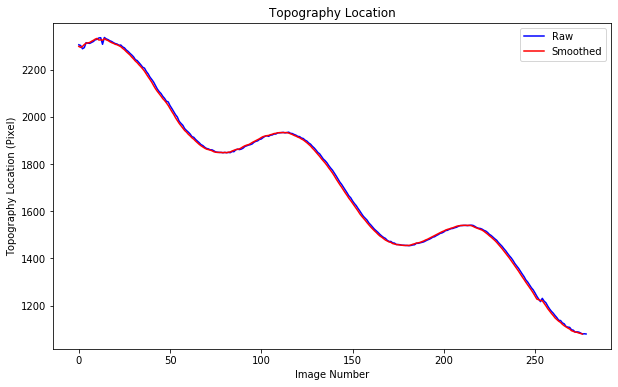

In [69]:
#checking that smoothing worked
plt.figure(figsize=(10,6))
plt.plot(topo_location,label='Raw',color='b')
plt.plot(topo_location_filt,label='Smoothed',color='r')
plt.legend()
plt.title('Topography Location')
plt.xlabel('Image Number')
plt.ylabel('Topography Location (Pixel)')

In [70]:
#now cropping images keeping the centre location constant

right = int(x-max(topo_location_filt))
left = int(min(topo_location_filt))

centre=np.zeros((t-2,y,right+left))

t=t-2
for i in range(t):
    topo=int(topo_location_filt[i]) 
    image=cropped_den[i+1]
    cropped_image=image[:,int(topo-left):int(topo+right)]
    centre[i]=cropped_image

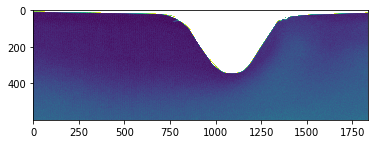

In [71]:
plt.imshow(centre[60])

0 of 277 Images Done!
25 of 277 Images Done!
50 of 277 Images Done!
75 of 277 Images Done!
100 of 277 Images Done!
125 of 277 Images Done!
150 of 277 Images Done!
175 of 277 Images Done!
200 of 277 Images Done!
225 of 277 Images Done!
250 of 277 Images Done!


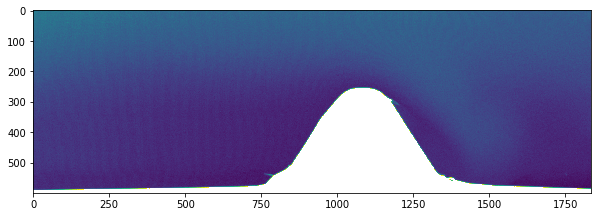

In [72]:
#using the same code as above to create a video to look at centred topo
ims=[]
fig = plt.figure(figsize=(10,5))

for i in range(t-2):
    
    image=centre[i][::-1]
    
    im=plt.imshow(image, animated=True)
    
    ims.append([im])

    
    if i % 25 == 0:
        print('{} of {} Images Done!'.format(i,t))
        
        
ani = animation.ArtistAnimation(fig, ims, interval=125, blit=True,
                                repeat_delay=1000)



writer = animation.writers['ffmpeg']
save_name = 'centre_test'.format(run_num)
ani.save('{}/densityfields2/{}.mp4'.format(os.path.dirname(foreground_path[0]),save_name), dpi=250)

In [73]:
g = 9.81
n=np.sqrt(g/1000*(rho_bottom-rho_top)/depth)

In [82]:
t,y,x=centre.shape
w=np.zeros((t-1,y,x))

delta_t=0.125
sf=1
scaling = -sf/n**2
for i in range(t-1):
    diff = (centre[i+1]-centre[i])/delta_t
    w[i] = cv2.medianBlur(np.float32(diff*scaling),5)

0 of 277 Images Done!
25 of 277 Images Done!
50 of 277 Images Done!
75 of 277 Images Done!
100 of 277 Images Done!
125 of 277 Images Done!
150 of 277 Images Done!
175 of 277 Images Done!
200 of 277 Images Done!
225 of 277 Images Done!
250 of 277 Images Done!
275 of 277 Images Done!


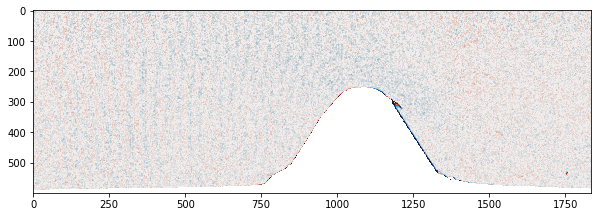

In [83]:
ims=[]
fig = plt.figure(figsize=(10,5))

for i in range(t-1):
    
    image=w[i][::-1]
    
    im=plt.imshow(image, animated=True,vmin=-10,vmax=10,cmap=cmo.cm.balance)
    
    ims.append([im])

    
    if i % 25 == 0:
        print('{} of {} Images Done!'.format(i,t))
        
        
ani = animation.ArtistAnimation(fig, ims, interval=125, blit=True,
                                repeat_delay=1000)


writer = animation.writers['ffmpeg']
save_name = 'w_test'.format(run_num)
ani.save('{}/densityfields2/{}.mp4'.format(os.path.dirname(foreground_path[0]),save_name), dpi=250)